In [180]:
import librosa
import matplotlib.pyplot as plt                                                 
import scipy.io.wavfile
import numpy as np
import math
from scipy.fftpack import dct
from silero_vad import load_silero_vad, read_audio, get_speech_timestamps,collect_chunks
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense
from tensorflow.keras.utils import image_dataset_from_directory
import torch
import torchaudio

In [5]:
# All the audio samples are single-channel(mono)
# Loads audio file from path and returns tuple of (sample rate, audio array)
def load_audio(path):
    sampleRate, audio = scipy.io.wavfile.read(path)
    sampleRate=audio.size
    return sampleRate,audio

In [128]:
# Time vs. Amplitude plot o original audio, loaded initially.
def plot_audio_init(audio):
    plt.figure(figsize=(12,5))
    plt.plot(audio)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Audio Signal")
    plt.show()
    plt.close()

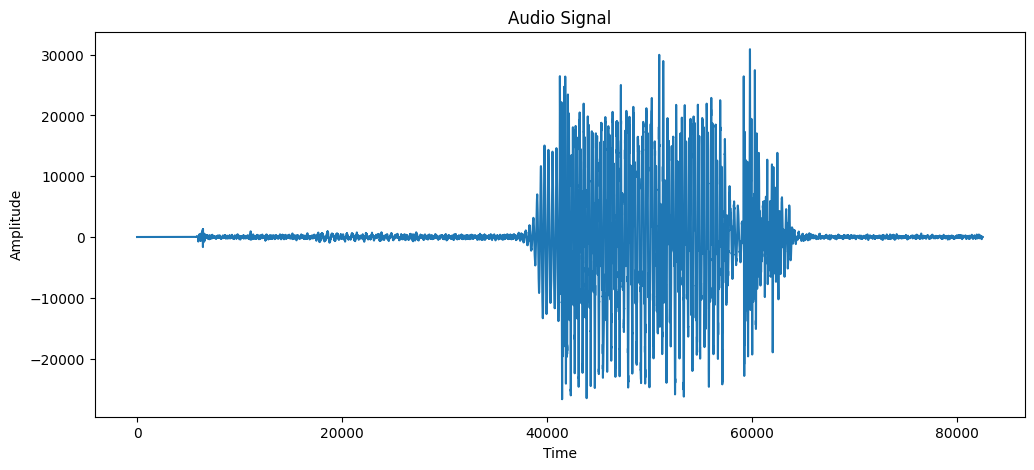

In [195]:
sampleRate,audio=load_audio("C:/users/svija/downloads/stt-engine/test/bird/test_bird.wav")
plot_audio_init(audio)

In [193]:
x_min=min(audio)
x_max=max(audio)
x_min=0
normed=((audio-x_min)/(x_max-x_min))
print(normed)
print(len(audio))

[ 0.00000000e+00 -3.23645543e-05 -3.23645543e-05 ... -1.84477960e-03
 -1.45640495e-03 -1.03566574e-03]
82456


In [ ]:
wav=read_audio('C:/users/svija/downloads/stt-engine/test/bird/test_bird.wav',sampling_rate=sampleRate)
clips=[
    {'start':0,'end':15999},
    {'start':16000,'end':31999},
    {'start':32000,'end':47999},
    {'start':48000,'end':63999},
    {'start':64000,'end':80000}
]
chunks=collect_chunks(clips,wav,sampling_rate=16000)
print(chunks.shape)
print(wav.shape)

torch.Size([27485])
torch.Size([27486])


In [161]:
# Voice-Activity Detection using Silero-VAD.
# Detects first instance of speech in an audio.
# If an error occurs or speech is not detected, function returns tuple of (-1,audio). 
# A check on returned sampleRate can be applied after function implementation to check if speech is detected without error, or not.

def vad(sampleRate,audio,path):
    wav, sr = torchaudio.load('C:/users/svija/downloads/stt-engine/test/bird/test_bird.wav')
    if sampleRate>16000:
        num_frames=math.floor(sampleRate/16000)

    frames=[]
    #0-16, 16-32, 32-48, 48-64, 64-80, 80-82
    for i in range(num_frames):
        x=np.array(audio[16000*i:16000*(i+1)]).astype(np.float32)
        frames.append([x])

    x=np.array(audio[16000*num_frames:sampleRate])
    x=np.append(x,[0]*(16000-(sampleRate-(16000*num_frames)))).astype(np.float32)
    frames.append([x])

    frames=np.stack(frames)
    
    model = load_silero_vad()

    for i in range(num_frames+1):
        # frame=torch.tensor([frames[i]])
        frame = torch.from_numpy(frames[i]).float()
        x_min=0
        x_max=frame.max()
        # print(x_min,x_max)
        frame_norm=(frame-x_min)/(x_max-x_min)
        f=frame_norm.squeeze(0)
        print(f)
        # print(frame-wav[0][0:16001])
        speech_timestamps = get_speech_timestamps(f,model)
        print(speech_timestamps)
        # try:
        #     x=speech_timestamps[0]['start']
        # except:
        #     continue
        # if speech_timestamps[0]['start']+int(0.375*sampleRate)>sampleRate:
        #     return -1,audio
        # else:
        #     speech_timestamps[0]['start']+int(0.375*sampleRate)
        # audio=audio[speech_timestamps[0]['start']:speech_timestamps[0]['start']+int(0.375*sampleRate)]
        # sampleRate=audio.size
        # print(speech_timestamps)
        # return sampleRate,audio
    return sampleRate,audio

#Time vs Amplitude plot of audio after voice-activity isolation
def plot_audio_vad(audio):
    plt.figure(figsize=(12,5))
    plt.plot(audio)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Audio Signal after VAD")
    plt.show()
    plt.close()

In [156]:
wav, sr = torchaudio.load('C:/users/svija/downloads/stt-engine/test/bird/test_bird.wav')
print(wav)

tensor([[ 0.0000e+00, -3.0518e-05, -3.0518e-05,  ..., -1.7395e-03,
         -1.3733e-03, -9.7656e-04]])


C:\Users\svija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [162]:
sampleRate,audio=vad(sampleRate,audio,"C:/Users/svija/Downloads/test/bird/test_bird.wav")
print(sampleRate)


tensor([ 0.0000, -0.0008, -0.0008,  ...,  0.0108, -0.0115, -0.0300])
[]
tensor([-0.0523, -0.0471, -0.0293,  ..., -0.0052,  0.0272,  0.0649])
[]
tensor([0.0037, 0.0051, 0.0064,  ..., 0.5497, 0.5402, 0.5651])
[]
tensor([ 0.5210,  0.5470,  0.5446,  ..., -0.0173, -0.0172, -0.0170])
[]
tensor([-0.4564, -0.4493, -0.4379,  ..., -0.0837, -0.0714, -0.0590])
[]
tensor([-0.1345, -0.1051, -0.0807,  ...,  0.0000,  0.0000,  0.0000])
[]
82456


In [ ]:
model=load_silero_vad()
wav=read_audio('audioData/Animals/bird/0a7c2a8d_nohash_0.wav')
print(wav.shape)
print(wav)
speech_timestamps = get_speech_timestamps(
  wav,
  model,
  return_seconds=True,  # Return speech timestamps in seconds (default is samples)
)
print(speech_timestamps)

torch.Size([16000])
tensor([-0.0002,  0.0009, -0.0016,  ...,  0.0004,  0.0005,  0.0009])
[{'start': 0.5, 'end': 1.0}]


C:\Users\svija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\silero_vad\utils_vad.py:139: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  list_backends = torchaudio.list_audio_backends()
C:\Users\svija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\silero_vad\utils_vad.py:150: UserWarning: torchaudio.sox_effects.sox_effects.apply_effects_file has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Plea

In [223]:
frames = np.random.rand(5)
print(torch.tensor([frames]))

tensor([[0.8866, 0.5818, 0.6686, 0.7833, 0.0911]], dtype=torch.float64)


In [225]:
wav, sr = torchaudio.load('C:/users/svija/downloads/stt-engine/test/bird/test_bird.wav')
print(wav)

tensor([[ 0.0000e+00, -3.0518e-05, -3.0518e-05,  ..., -1.7395e-03,
         -1.3733e-03, -9.7656e-04]])


In [48]:
# To generate MFCC, we follow the following steps:
# audioInput -> pre-emphasis -> framing -> windowing -> fourier transform -> Inverse Mel Scale Filter Bank -> Log() -> DCT

In [ ]:
# Pre-emphasis layer
# Amplifies higher frequencies in order to balance the spectrum (higher frequencies have lower energies)
def pre_emphasize(sampleRate,audio):
    pre_emphasis = 0.97
    audio_preemphasized=[]
    for i in range(1,sampleRate):
        audio_preemphasized=np.append(audio_preemphasized,audio[i]-(audio[i-1]*pre_emphasis))

    return audio_preemphasized

# Time vs. Amplitude plot of audio after pre-emphasis
def plot_audio_pre_emphasis(audio_preemphasized):
    # Plot the pre-emphasized signal
    plt.figure(figsize=(14, 5))
    plt.plot(audio_preemphasized)
    plt.title('Pre-emphasized Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()
    plt.close()

In [ ]:
# Framing Layer
# Since the audio wave is more than a second, windowing is necesarry in order to fully capture the features and allow for correct
# calculations to be performed. Thus, for ease of calculations, we slice the wave.
# The signal/wave is separated into sections or frames of 25-30 milliseconds.
# Since some parts of the signal are always at the ends of the frames, and we have to perform hamming window, this may result in data loss.
# To tackle this, we frame-shift with a stride of 15ms. This ensures that parts of signals get to be in the center of the signal.

def frame_audio(sampleRate,audio_preemphasized):
    shift_stride=220  # ~10 millisecond of stride
    frame_size=650 # ~30 millisecond frame
    audio_frames=[]

    # Produces 65 audio frames
    for i in range(0,sampleRate-frame_size,shift_stride):
        audio_frames.append(audio_preemphasized[i:i+frame_size])

    return frame_size,audio_frames

# Time vs. Amplitude plot of audio after framing
def plot_audio_frame(audio_frames):
    plt.figure(figsize=(12,4))
    plt.plot(audio_frames[2])
    plt.title('Framed Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()
    plt.close()

In [ ]:
# Windowing Layer
# Since sudden increase/decrease of amplitude at the edges of the frames create noisy outcomes, we have to smoothen it.
# Thus, we apply hamming window

def hamm_audio(sampleRate,frame_size,audio_frames):
    hammed_audio=[]
    for frame in audio_frames:
        temp_hammed_audio=[]
        for i in range(0,frame_size):
            temp_hammed_audio.append(frame[i]*(0.54-0.46*math.cos(2*math.pi*i/(frame_size-1))))
        
        hammed_audio.append(temp_hammed_audio)

    return hammed_audio

# Time vs. Amplitude plot of audio after application of hamming window
def plot_audio_hammed(hammed_audio):
    plt.figure(figsize=(12,4))
    plt.plot(hammed_audio[2])
    plt.title('Windowed Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()
    plt.close()

In [ ]:
# FFT(Fast Fourier Transform) Layer
# Used to convert time-domain signal to frequency-domain to analyze frequency components of speech.
# Output of FFT gives complex frequency spectrum (both magnitude and phase)
# Since we only need magnitude, we evaluate the power spectrum from the output of FFT
# NFFT specifies number of points for the FFT. The output is NFFT/2 points

def pow_spec(hammed_audio):
    NFFT=2048
    complex_power_spectrums=np.fft.rfft(hammed_audio,NFFT)
    power_spectrum=(1/NFFT)*pow(np.abs(complex_power_spectrums),2)
    return NFFT,power_spectrum

# Frequency vs. Power/Frequency plot of audio after FFT
def plot_power_spectrum(power_spectrum):
    plt.figure(figsize=(12,4))
    plt.plot(power_spectrum[2])
    plt.title("Power Spectral Density")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power/Frequency (dB/Hz)")
    plt.show()
    plt.close()

In [ ]:
# Mel-filter banks
# Mel-scale related to human-percieved frequency to its actual frequency. Since humans do not hear sound linearly,
# i.e, linear gaps in frequency does not amount to linear change in pitch, we use mel-scale.
# Mel-scale is a logarithm scale, which imitates hearing of humans. Thus, it enables us to capture features as if heard by human.

# Computing the Mel-Filter bank
# 1. Decide upper and lower frequencies in Hertz(SampleRate/2 and 300Hz repectively) 
# 2. Convert them to mels.
# 3. Compute 12 linearly-spaced frequencies inclusive of lower and upper mels.
# 4. Convert these points back to Hertz.
# 5. Round the frequencies to their nearest FFT Bins.
# 6. Create Filterbanks


# Creates frequency bins and returns tuple of (number of filters, frequency bins)
def mels(sampleRate,NFFT):
    freq_to_mel=lambda freq:1125*math.log(1+freq/700)
    lower_hz=300
    upper_hz=sampleRate/2

    lower_mel=freq_to_mel(lower_hz)
    upper_mel=freq_to_mel(upper_hz)

    n_filters=40
    mel_arr=np.linspace(lower_mel,upper_mel,n_filters+2)
    hz_arr=[700*(math.exp((i/1125))-1) for i in mel_arr]

    freq_bin=[math.floor((NFFT+1)*hz_arr_i/sampleRate) for hz_arr_i in hz_arr]
    return n_filters,freq_bin


In [ ]:
# Computing the filterbanks.
# Returns filter_banks
def mel_filterbanks(NFFT,n_filters,freq_bin,power_spectrum):
    temp_filter_bank=np.zeros((n_filters,int((NFFT/2))+1))
    for i in range(1,n_filters+1):
        for k in range(0,int((NFFT/2))):  #frame length
            if k<freq_bin[i]:
                temp_filter_bank[i-1][k]=0
            elif freq_bin[i-1]<=k and k<=freq_bin[i]:
                temp_filter_bank[i-1][k]=(k-freq_bin[i-1])/(freq_bin[i]-freq_bin[i-1])
            elif freq_bin[i]<=k and k<=freq_bin[i+1]:
                temp_filter_bank[i-1][k]=(freq_bin[i+1]-k)/(freq_bin[i+1]-freq_bin[i])
            else:
                temp_filter_bank[i-1][k]=0


    filter_banks=np.dot(power_spectrum, temp_filter_bank.T)
    filter_banks=np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks=np.log(filter_banks+1e-8)

    return filter_banks

# Mel-Spectogram plot of filter banks
def plot_mel_spectogram(sampleRate,filter_banks):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(filter_banks.T, sr=sampleRate, x_axis='time', y_axis='mel',cmap='turbo')
    plt.colorbar()
    plt.title("Mel-Spectogram")
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
# Generate MFCCs
# We apply DCT on the filterbanks to obtain a set of 26 Mel-Frequency Cepstral Coefficients.
# We only require first 13 coefficients for ASR purposes. Rest are to be discarded.
# Returns mfcc
def gen_mfcc(filter_banks):
    mfcc = dct(filter_banks, type=2, axis=1)[:, 1:13] # Keep 2-13
    return mfcc

# Plot of first 13 Mel-Frequency Cepstral Coefficients
def plot_mfcc(sampleRate,mfcc):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mfcc.T, sr=sampleRate, x_axis='time', y_axis='mel',cmap='turbo',vmin=-100,vmax=100)
    plt.colorbar()
    plt.title("Mel-Cepstral Frequency Coefficients")
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
# To simplify the process of getting MFCC:
#   get_mfcc(path), returns tuple (flag,mfcc).
#       input(String: path)
#       gets audio file from the path and applies necessary functions to obtain Mel-Frequency Cepstral Coefficients.
#       If, during loading of audio or application of VAD, some error occurs, sampleRate

def get_mfcc(path):
    flag=0
    sampleRate,audio=load_audio(path)
    sampleRate,audio=vad(sampleRate,audio,path)
    if sampleRate==-1:
        flag=1
        return flag,flag
    audio_preemphasized=pre_emphasize(sampleRate,audio)
    frame_size,audio_frames=frame_audio(sampleRate,audio_preemphasized)
    hammed_audio=hamm_audio(sampleRate,frame_size,audio_frames)
    NFFT,power_spectrum=pow_spec(hammed_audio)
    n_filters,freq_bin=mels(sampleRate,NFFT)
    filter_banks=mel_filterbanks(NFFT,n_filters,freq_bin,power_spectrum)
    mfcc=gen_mfcc(filter_banks)
    return flag,mfcc

def get_mel_filterbanks(path):
    sampleRate,audio=load_audio(path)
    sampleRate,audio=vad(sampleRate,audio,path)
    audio_preemphasized=pre_emphasize(sampleRate,audio)
    frame_size,audio_frames=frame_audio(sampleRate,audio_preemphasized)
    hammed_audio=hamm_audio(sampleRate,frame_size,audio_frames)
    NFFT,power_spectrum=pow_spec(hammed_audio)
    n_filters,freq_bin=mels(sampleRate,NFFT)
    filter_banks=mel_filterbanks(NFFT,n_filters,freq_bin,power_spectrum)
    return filter_banks

In [ ]:
# Extracts MFCCs from the audio files provided in the input_path and stores the MFCC images at output_path

def prepare_training_data(input_path,output_path):
    os.makedirs(output_path, exist_ok=True)
    file_names = os.listdir(input_path)
    for file in file_names:
        flag,mfcc=get_mfcc(input_path+file)
        if flag==1:
            continue
        fig=plt.figure(figsize=(1, 1),frameon=False)
        librosa.display.specshow(mfcc.T, x_axis='time', y_axis='mel',cmap='turbo',vmin=-100,vmax=100)   
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_path+file+".png")
        plt.close()

In [ ]:
# # THIS CELL MUST ONLY BE EXECUTED IF YOU WANT TO EXTRACT MFCCs.
# # IF THE MFCCs ARE ALREADY STORED, DO NOT RUN THIS CELL. COMMENT THE CODE BELOW

# #For audio containing word "dog"
# input_path="C:/Main/Dev/Github/Py-STT-Engine-venv/Py-STT-Engine/audioData/Animals/dog/"
# output_path="C:/Main/Dev/Github/Py-STT-Engine-venv/Py-STT-Engine/mfccs_all/dog/"

# prepare_training_data(input_path,output_path)

In [ ]:
# # THIS CELL MUST ONLY BE EXECUTED IF YOU WANT TO EXTRACT MFCCs.
# # IF THE MFCCs ARE ALREADY STORED, DO NOT RUN THIS CELL. COMMENT THE CODE BELOW

# #For audio containing word "cat"
# input_path="C:/Main/Dev/Github/Py-STT-Engine-venv/Py-STT-Engine/audioData/Animals/cat/"
# output_path="C:/Main/Dev/Github/Py-STT-Engine-venv/Py-STT-Engine/mfccs_all/cat/"

# prepare_training_data(input_path,output_path)

In [ ]:
# # THIS CELL MUST ONLY BE EXECUTED IF YOU WANT TO EXTRACT MFCCs.
# # IF THE MFCCs ARE ALREADY STORED, DO NOT RUN THIS CELL. COMMENT THE CODE BELOW

# #For audio containing word "bird"
# input_path="C:/Main/Dev/Github/Py-STT-Engine-venv/Py-STT-Engine/audioData/Animals/bird/"
# output_path="C:/Main/Dev/Github/Py-STT-Engine-venv/Py-STT-Engine/mfccs_all/bird/"

# prepare_training_data(input_path,output_path)

In [ ]:
# Now that the MFCCs are extracted fromt he give audio files, we choose a neural network for classification.
# For current usage and for the sake of experiment and learning, we use a Convolutional Neural Network that takes in whole MFCC
# plot-image of the image and produces a classification based on them.

# However, this method may not be useful when we have an audio file that consists of sentences and not just a single word.
# We may need a recurrent neural network for those purposes.

In [ ]:
# # An MFCC plot-image of an audio is of dimensions (100,100,3)
# # To pass on the images to a CNN, we create a tensor object from the images and use those tensors to train the CNN model.


# # image_dataset_from_directory checks for subdirectories in the path provided, and treats those subdirectories as categories or classes.
# # The images inside those subdirectories are used as data of those categories and are turned into tensors.
# # validation_split=0.2, which means that 20% of all the data is used as validation data, rest is used as training data.
# # subset='training', means that the dataset is to be used for training
# # seed=123, seed for shuffling the order
# # shuffle=True, to shuffle all the tensors
# # labels='inferred', labels are taken from the subdirectories of the path directory.

# # Make sure that MFCCs are extracted before running this cell.
# train_dataset=image_dataset_from_directory('mfccs_all/',validation_split=0.2,subset="training",
#   seed=123,labels='inferred',image_size=(100,100),batch_size=1,shuffle=True)

# # subset='validation', means that the dataset is to be used for validation
# validate_dataset=image_dataset_from_directory('mfccs_all/',validation_split=0.2,subset="validation",
#   seed=123,labels='inferred',image_size=(100,100),batch_size=1,shuffle=True)

In [ ]:
# Check the data.
# image tensor(tf.tensor) needs to be converted to numpy array and normalized to range 0-1, for appropriate plot.
# label tensor's 0th index contains the label.
# 0 = Bird
# 1 = Cat
# 2 = Dog
# num is used to iterate over num images and labels in dataset
def check_dataset(dataset,num):
    for image_tensor,label_tensor in train_dataset:
        if num<=0:
            break
        image=image_tensor.numpy()
        image=image[0]/255
        label=label_tensor[0].numpy()
        cv2.imshow(f"{label}",image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        num-=1

    
# check_dataset(train_dataset,3)

In [ ]:
# # Configuring Convolutional Neural Network to parse and classify MFCC-plots.
# # Initial Dimensions of an image are (100,100,3)
# model=Sequential()

# #Input: (x_dim,y_dim,num_images)
# #Input: 100, 100, 1
# model.add(Conv2D(8,(3,3),activation='relu',input_shape=(100,100,3),padding='valid'))
# model.add(MaxPool2D((2,2),padding='valid'))

# #Input: 49, 49, 8
# model.add(Conv2D(16,(3,3),activation='relu',padding='valid'))
# model.add(MaxPool2D((2,2),padding='valid'))

# #Input: 23, 23, 16
# model.add(Conv2D(32,(3,3),activation='relu',padding='valid'))
# model.add(MaxPool2D((2,2),padding='valid'))

# #Input: 10, 10, 32
# model.add(Conv2D(64,(3,3),activation='relu',padding='valid'))
# model.add(MaxPool2D((2,2),padding='valid'))

# #Input: 4, 4, 64
# model.add(Flatten())

# #Input: 1024 1D-Array
# model.add(Dense(1024,activation='relu'))
# model.add(Dense(200,activation='relu'))
# model.add(Dense(3,activation='softmax'))

In [ ]:
# model.summary()

In [ ]:
# # Compile multiple models based on prediction values.
# # Here, 7 models have been compiled with different configurations of convolutional layers, number of kernels per layer,
# # and number of fully connected layers with differing neurons.

# model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
# history = model.fit(
#   train_dataset,
#   epochs=1
# )

In [ ]:
# loss,accuracy=model.evaluate(validate_dataset)

In [ ]:
# All the models are saved for later evaluations and comparisons.

# model.save('models/cnn7.keras')

In [ ]:
# # Reload the saved models and compare the accuracies over 10 iterations of predictions
# # Results are saved in the results dictionary, with keys as mean accuracy and values as model path.

# iter=10
# model_paths=os.listdir('models/')
# results={}
# for path in model_paths:
#     model=tf.keras.models.load_model('models/'+path)
#     total_acc=0
#     for i in range(iter):
#         loss,accuracy=model.evaluate(validate_dataset,verbose=0)
#         total_acc+=accuracy

#     results[total_acc/iter]='models/'+path

In [ ]:
# # Pick the best model
# best_model=results[max(results.keys())]
# print(f"Best model: {best_model}")
# print(f"Avg accuracy: {max(results.keys())}")
# model=tf.keras.models.load_model(best_model)
# model.save('best_model.keras')

In [ ]:
# # Evaluate model on test images

# loss,accuracy=model.evaluate(validate_dataset)

In [ ]:
prepare_training_data('C:/Users/svija/Downloads/test/bird/','C:/Users/svija/Downloads/testmfcc/bird/')
prepare_training_data('C:/Users/svija/Downloads/test/cat/','C:/Users/svija/Downloads/testmfcc/cat/')
prepare_training_data('C:/Users/svija/Downloads/test/dog/','C:/Users/svija/Downloads/testmfcc/dog/')

16000
16000
16000
16000
16000
0
<class 'torch.Tensor'>
<class 'numpy.ndarray'>


C:\Users\svija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\silero_vad\utils_vad.py:139: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  list_backends = torchaudio.list_audio_backends()
C:\Users\svija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\silero_vad\utils_vad.py:150: UserWarning: torchaudio.sox_effects.sox_effects.apply_effects_file has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Plea

ValueError: expected sequence of length 16000 at dim 1 (got 0)

In [ ]:
test_data=image_dataset_from_directory('C:/Users/svija/Downloads/testmfcc/',
  seed=123,labels='inferred',image_size=(100,100),batch_size=1)

Found 3 files belonging to 3 classes.


In [ ]:
model=tf.keras.models.load_model('best_model.keras')

In [ ]:
loss,accuracy=model.evaluate(test_data,verbose=1)
print(accuracy)

C:\Users\svija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend\tensorflow\nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 2.5748  
0.0


In [ ]:
for im,lb in test_data:
    print(lb[0].numpy())

0
2
1


In [ ]:
print(pred)

[[0.01305619 0.8139963  0.17294751]
 [0.02438117 0.70760506 0.26801375]
 [0.97608143 0.02182275 0.0020958 ]]


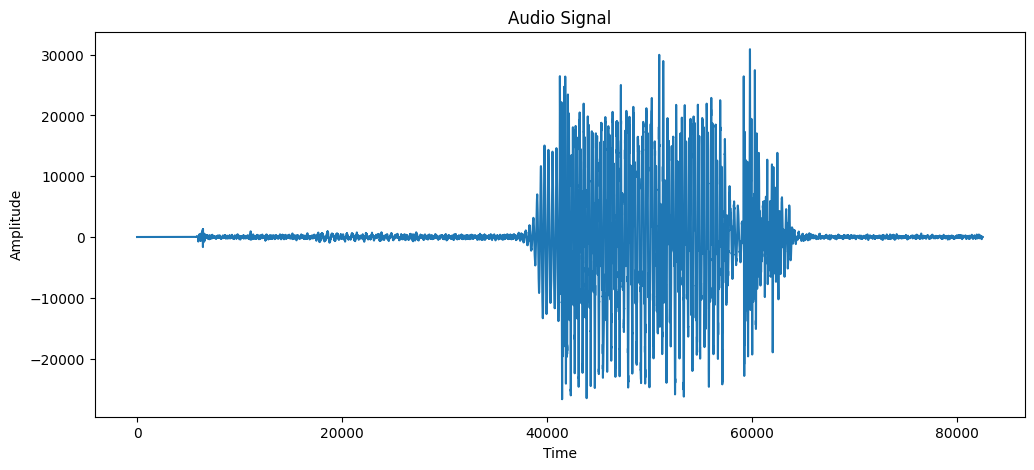

82456


In [ ]:
sampleRate,audio=load_audio("C:/Users/svija/Downloads/test/bird/test_bird.wav")
plot_audio_init(audio)
print(sampleRate)

In [ ]:
sampleRate,audio=vad(sampleRate,audio,"C:/Users/svija/Downloads/test/bird/test_bird.wav")
print(sampleRate)

16000
16000
16000
16000
16000


IndexError: list index out of range